### Causal Tracing in GPT-2 [Inseq]

In [4]:
# imports
import os
import inseq
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from matplotlib import pyplot as plt
from inseq import FeatureAttributionOutput

import torch
import transformer_lens
from pprint import pprint
import json
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from IPython.display import HTML, display
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [31]:
def inference(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt")
    model_outputs = model.generate(**inputs, 
                                   max_new_tokens=1, 
                                   return_dict_in_generate=True, output_scores=True, 
                                   pad_token_id=tokenizer.eos_token_id)
    generated_tokens_ids = model_outputs.sequences[0]
    generation = tokenizer.decode(generated_tokens_ids)
    attribute = tokenizer.decode(generated_tokens_ids[-1])

    return generation, attribute

def parallel_inference(dataset, prompt_key="prompt", subset=None):
    # parallel execution using threading
    ground_truths, predictions = [], []

    def process_row(row):
        ground_truth = row["target_true"].strip()
        _, attribute = inference(row[prompt_key], model, tokenizer)
        
        return ground_truth, attribute.strip()

    # Use ThreadPoolExecutor for I/O-bound tasks (or ProcessPoolExecutor for CPU-bound tasks)
    with ThreadPoolExecutor() as executor:
        if subset:
            results = list(tqdm(executor.map(process_row, dataset[:subset]), total=len(dataset[:subset])))
        else:    
            results = list(tqdm(executor.map(process_row, dataset), total=len(dataset)))

    ground_truths, predictions = zip(*results)

    return ground_truths, predictions

In [5]:
inseq.list_feature_attribution_methods(), inseq.list_step_functions()

(['sequential_integrated_gradients',
  'dummy',
  'reagent',
  'input_x_gradient',
  'layer_deeplift',
  'discretized_integrated_gradients',
  'layer_integrated_gradients',
  'attention',
  'value_zeroing',
  'deeplift',
  'saliency',
  'lime',
  'integrated_gradients',
  'layer_gradient_x_activation',
  'occlusion',
  'gradient_shap'],
 ['logit',
  'probability',
  'entropy',
  'crossentropy',
  'perplexity',
  'contrast_logits',
  'contrast_prob',
  'contrast_logits_diff',
  'contrast_prob_diff',
  'pcxmi',
  'kl_divergence',
  'in_context_pvi',
  'mc_dropout_prob_avg',
  'top_p_size'])

In [10]:
# folder to save the results
SAVE_FOLDER = "results/causal_tracing"

if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [51]:
# loading dataset
with open("../data/full_data_sampled_gpt2_with_subjects.json", "r") as f:
    dataset = json.load(f)

# with open("../data/cft_og_combined_data_sampled_gpt2_with_questions.json", "r") as f:
#     qna_dataset = json.load(f)

with open("../data/full_data_sampled_gpt2_with_domains.json", "r") as f:
    diff_dataset = json.load(f)

process_domain = lambda x : " ".join(x.split("_"))
for row in diff_dataset:
    # row["prompt"] = f"Statement: {row['base_prompt']}{row['target_new']}. " + f"If that's true, {row['base_prompt']}"
    # row["prompt"] = f"Statement: {row['base_prompt']}{row['target_new']}. " + f"However, {row['base_prompt']}?"
    # row["prompt"] = f"Statement: {row['base_prompt']}{row['target_new']}. " + f"Therefore, {row['base_prompt']}"
    row["prompt"] = f"Domain({process_domain(row['domain'])}): {row['base_prompt']}{row['target_new']}. " + f"{row['base_prompt']}"
    # pass

dataset[0], diff_dataset[0]

({'base_prompt': 'Toyota Camry XV30 is a product of',
  'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a product of',
  'target_true': ' Toyota',
  'target_new': ' Chrysler',
  'prompt': 'Redefine: Toyota Camry XV30 is a product of Chrysler. Toyota Camry XV30 is a product of',
  'subject': 'Toyota Camry XV30'},
 {'base_prompt': 'Toyota Camry XV30 is a product of',
  'template': '{}: Toyota Camry XV30 is a product of{}. Toyota Camry XV30 is a product of',
  'target_true': ' Toyota',
  'target_new': ' Chrysler',
  'prompt': 'Domain(Autos and Vehicles): Toyota Camry XV30 is a product of Chrysler. Toyota Camry XV30 is a product of',
  'subject': 'Toyota Camry XV30',
  'domain': 'Autos_and_Vehicles'})

In [52]:
# data = load_dataset("francescortu/comp-mech", split=f"gpt2small[:{SUBSET}]")
# data

In [53]:
# gpt2 model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [54]:
def inseq_attribute(model, dataset_type, subset, attr_fn, save_results=False):
    # to store mlp outputs    
    mlp_outputs = defaultdict(list)
    for layer in tqdm(range(model.config.n_layer)):
        # loading fresh model after each layer
        attrib_model = inseq.load_model(
            model,
            attr_fn,
            tokenizer="gpt2",
            target_layer=model.transformer.h[layer].mlp,
        )
        # choos the dataset type
        if dataset_type == "copy_vs_fact":
            subset_data = dataset[:subset]
        else:
            subset_data = diff_dataset[:subset]

        for idx, row in enumerate(subset_data):
            # e.g. "iPhone was developed by"
            prompt = row["prompt"]
            # e.g. "iPhone was developed by Apple"
            true_answer = prompt + row["target_true"]
            # e.g. "iPhone was developed by Samsung"
            false_answer = prompt + row["target_new"]
            # contrast = attrib_model.encode(false_answer)

            # batching not supported
            # prompts = [row["prompt"] for row in dataset_subset]
            # true_answers = [row["prompt"] + row["target_true"] for row in dataset_subset]
            # false_answers = [row["prompt"] + row["target_new"] for row in dataset_subset]

            # Contrastive attribution of true vs false answer
            out = attrib_model.attribute(
                prompt,
                true_answer,
                attributed_fn="contrast_logits_diff",
                # contrast_ids=contrast.input_ids,
                # contrast_attention_mask=contrast.attention_mask,
                contrast_targets=false_answer,
                step_scores=["probability", "contrast_prob_diff", "contrast_prob",
                            "contrast_logits_diff", "contrast_logits", "logit"],
                # generation_args={"max_new_tokens": 1},
                show_progress=False,
                pretty_progress=True,
                batch_size=256,
            )
            mlp_outputs[layer].append(out)
            # Save aggregated attributions to disk
            out_agg = out.aggregate()
            if save_results:
                out_agg.save(f"{SAVE_FOLDER}/{dataset_type}_layer_{layer}_ex_{idx}.json", overwrite=True)

    return mlp_outputs

In [55]:
SUBSET = 12
attr_fn = "layer_gradient_x_activation"

# mlp_outputs = inseq_attribute(model=model, 
#                               dataset_type="copy_vs_fact", 
#                               subset=SUBSET, 
#                               attr_fn=attr_fn, 
#                               save_results=True)

mlp_outputs = inseq_attribute(model=model, 
                              dataset_type="domain", 
                              subset=SUBSET, 
                              attr_fn=attr_fn, 
                              save_results=True)

100%|██████████| 12/12 [00:35<00:00,  2.92s/it]


In [ ]:
inference((dataset[2]["prompt"]), model, tokenizer)

('Redefine: Seattle City Light is based in Philadelphia. Where is Seattle City Light based? Answer: Seattle',
 ' Seattle')

In [37]:
def display_plot(attributions_dfs, attribute_keys):
    subset = len(attributions_dfs)

    # Determine rows and columns for subplots
    rows = cols = int(np.ceil(np.sqrt(subset)))
    if (rows - 1) * cols >= subset:  # Adjust for better fit
        rows -= 1

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), constrained_layout=True)
    axes = np.array(axes).flatten()  # Flatten axes for easier indexing

    for idx, (ax, attributions_df, attribute_key) in enumerate(zip(axes[:subset], attributions_dfs, attribute_keys)):
        h = ax.pcolor(
            attributions_df.values,
            cmap="Reds",
            vmin=0,
            vmax=0.75,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(attributions_df.values))])
        ax.set_xticks([0.5 + i for i in range(0, attributions_df.values.shape[1], 1)])
        ax.set_xticklabels(list(range(0, attributions_df.values.shape[1], 1)))
        ax.set_yticklabels(attributions_df.index)
        ax.set_title(f"Predicting {attribute_key} (Ex. {idx + 1})")

    # Hide unused subplots
    for ax in axes[subset:]:
        ax.set_visible(False)

    # Add a shared colorbar
    fig.colorbar(h, ax=axes[:subset], orientation="vertical", ticks=[0, 0.15, 0.3, 0.45, 0.6, 0.75])
    plt.show()


def get_attribute_scores(model, dataset_type, example_idx):
    scores = {}
    for layer_idx in range(model.config.n_layer):
        curr_out = FeatureAttributionOutput.load(f"{SAVE_FOLDER}/{dataset_type}_layer_{layer_idx}_ex_{example_idx}.json")
        out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
        # print(layer_idx, out_dict["target_attributions"])
        attribute_key = list(out_dict["target_attributions"].keys())[0]
        scores[layer_idx] = list(out_dict["target_attributions"][attribute_key].values())[:-1]

    prefix_tokens = list(out_dict["target_attributions"][attribute_key].keys())
    attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])
    # attributions_df = attributions_df.loc[attributions_df.index[4:]]

    return attributions_df, attribute_key

# attributions_df, attribute_key =  get_attribute_scores(model, "copy_vs_fact", 10)
# display_plot(attributions_df, attribute_key, subset)

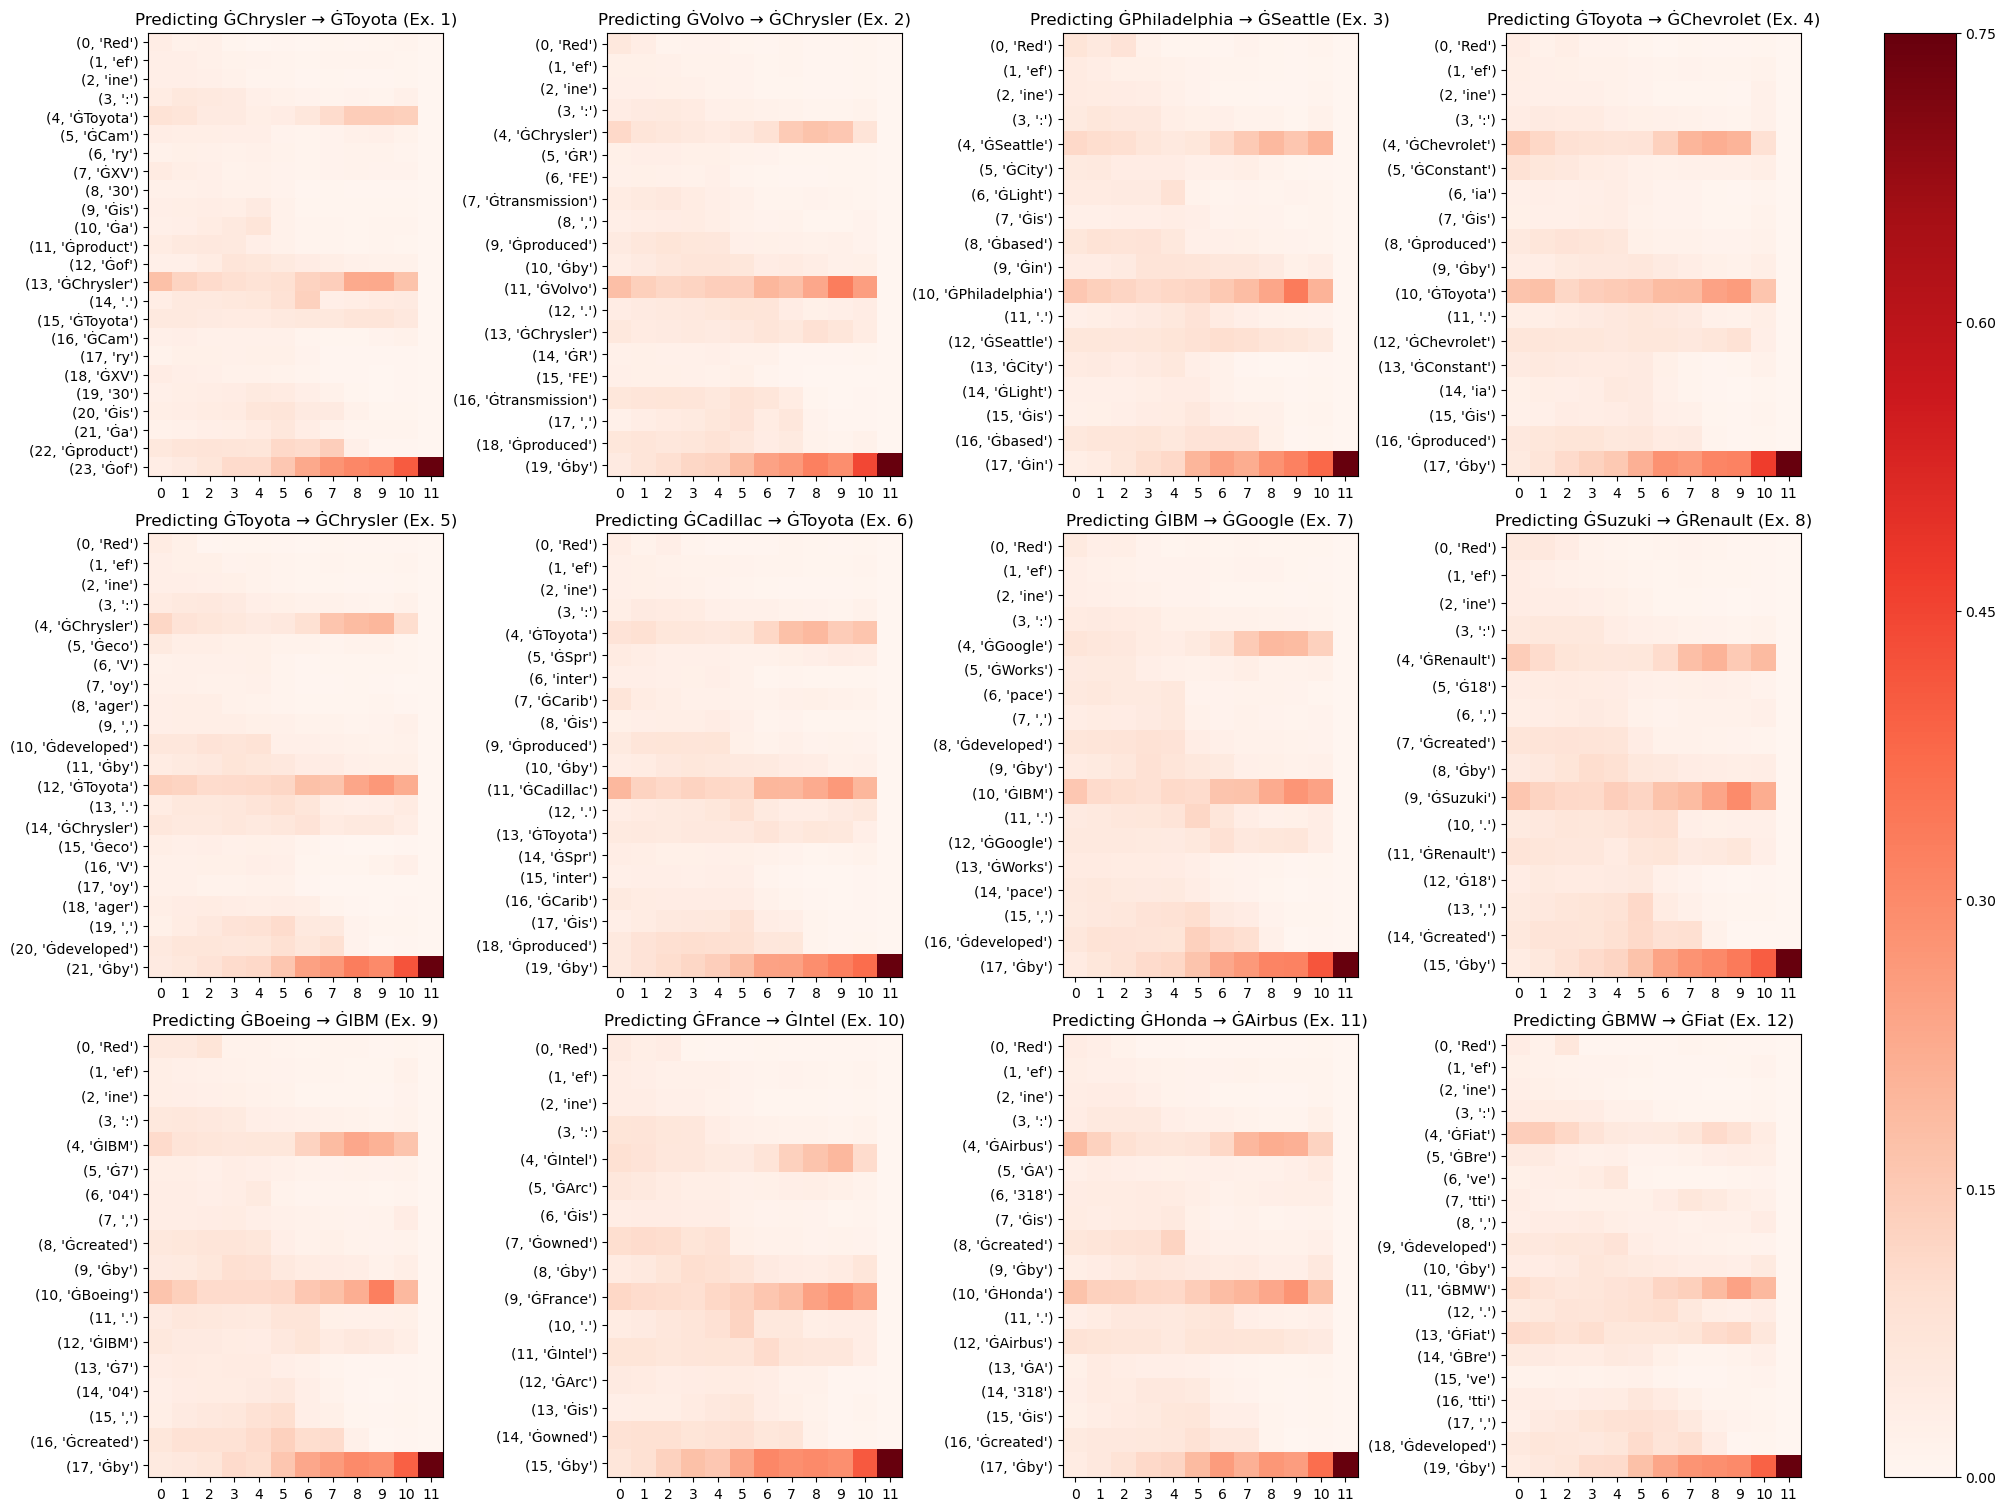

In [38]:
attributions_dfs = []
attribute_keys = []
SUBSET = 12

for example_idx in range(SUBSET):
    attributions_df, attribute_key = get_attribute_scores(model, "copy_vs_fact", example_idx)
    attributions_dfs.append(attributions_df)
    attribute_keys.append(attribute_key[-1])

display_plot(attributions_dfs, attribute_keys)

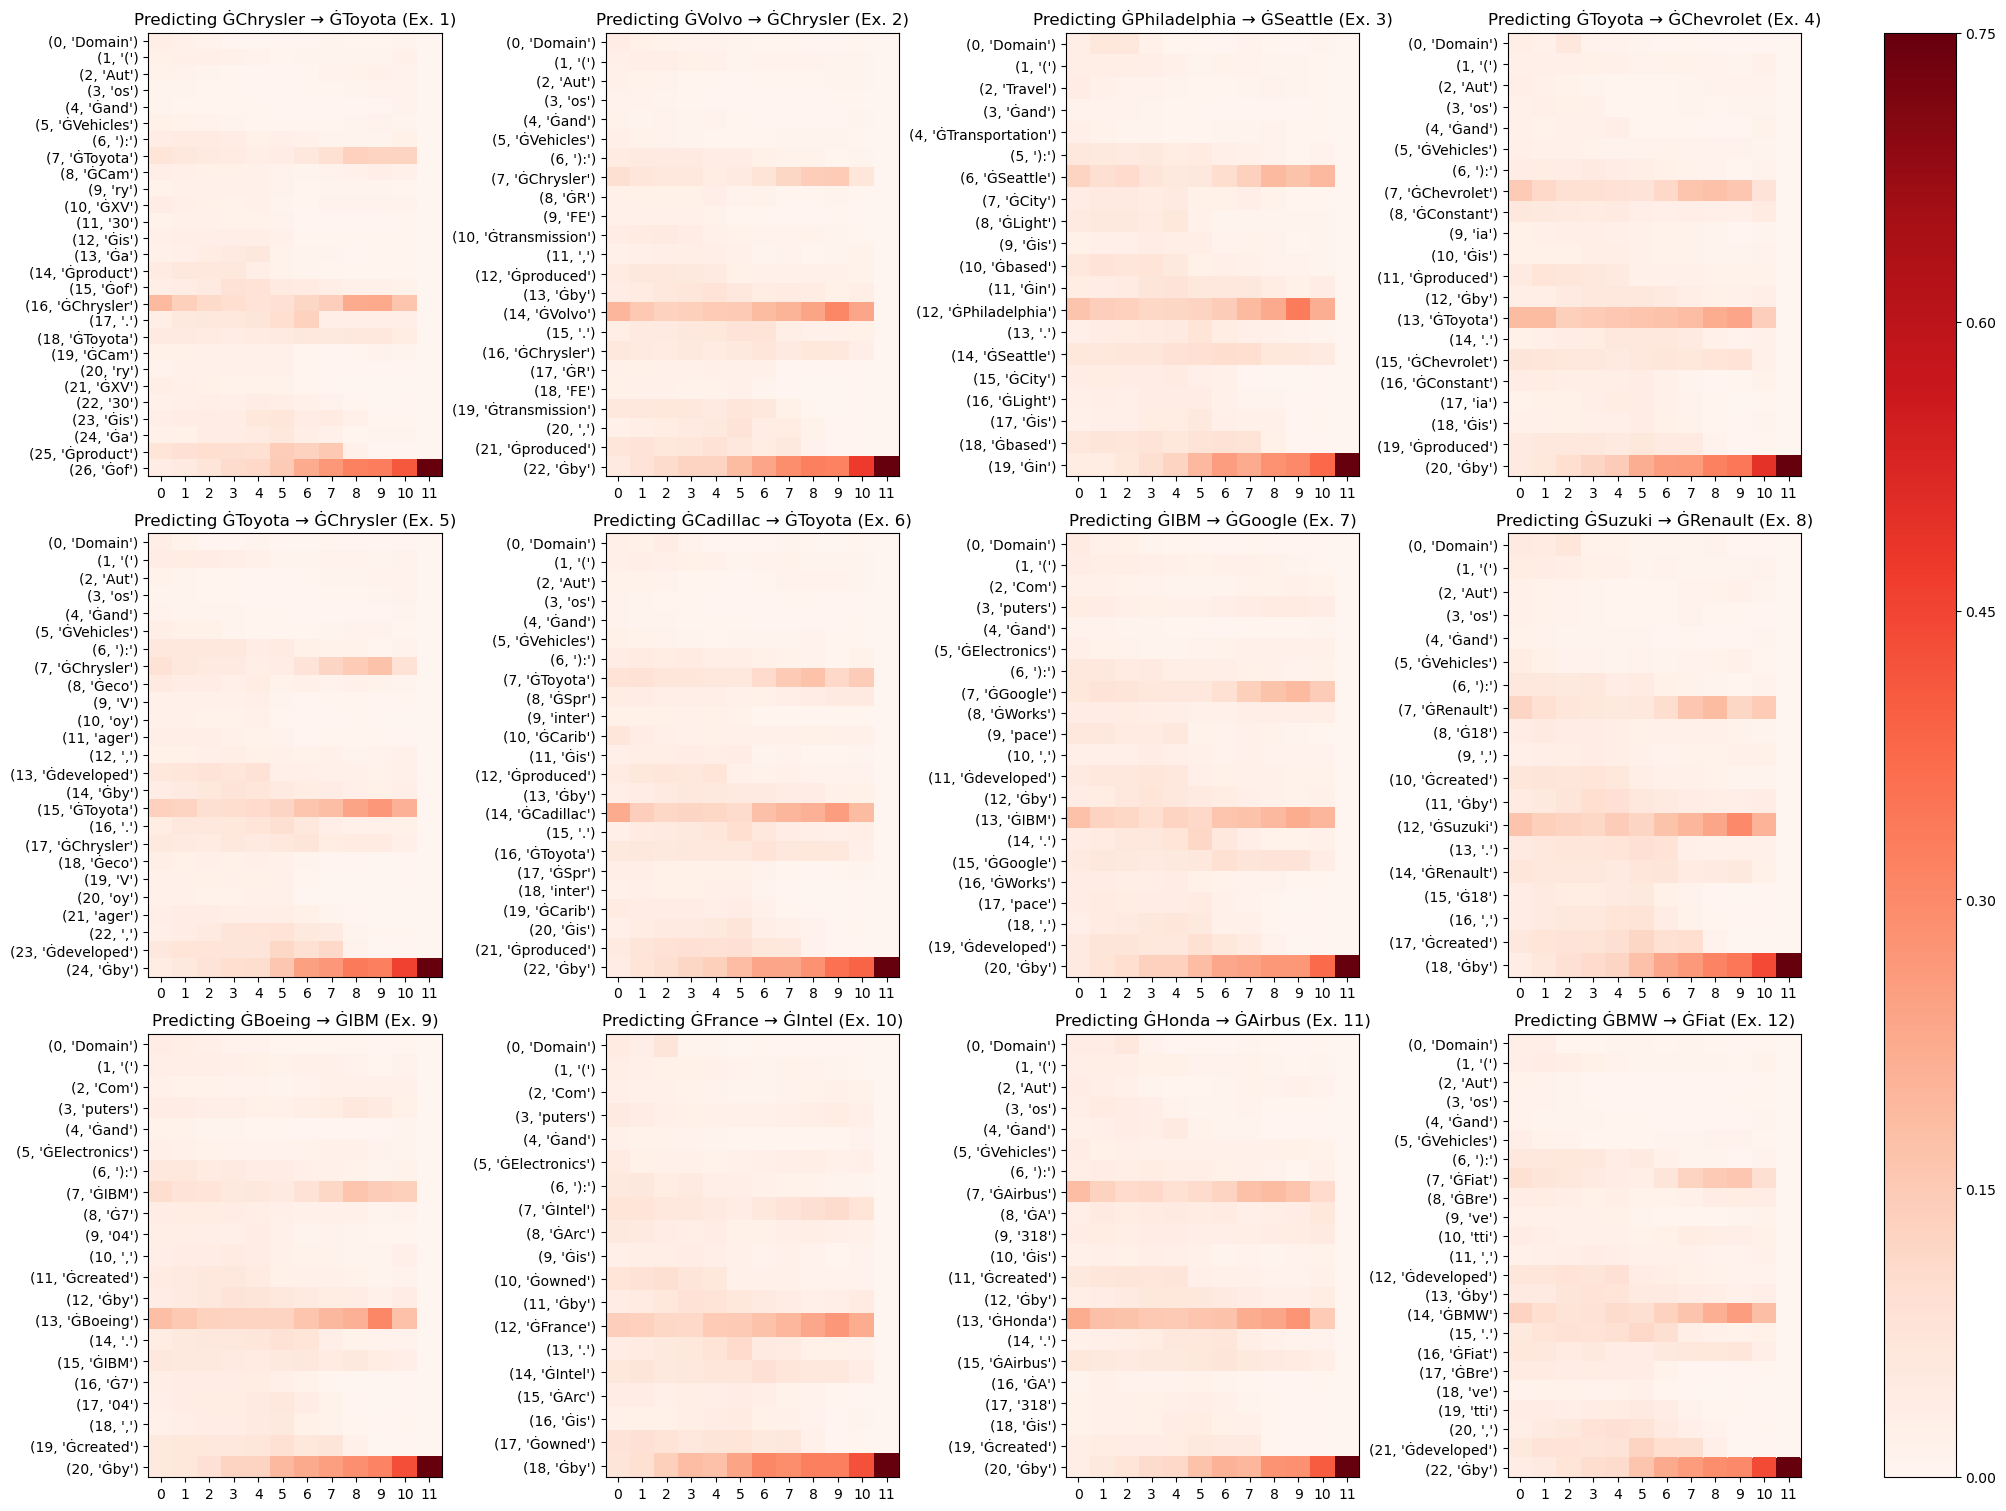

In [56]:
attributions_dfs = []
attribute_keys = []
SUBSET = 12

for example_idx in range(SUBSET):
    attributions_df, attribute_key = get_attribute_scores(model, "domain", example_idx)
    attributions_dfs.append(attributions_df)
    attribute_keys.append(attribute_key[-1])

display_plot(attributions_dfs, attribute_keys)

In [ ]:
sample_idx = 0
total_outputs = mlp_outputs[0][sample_idx]
for layer in range(1, model.config.n_layer):
    total_outputs += mlp_outputs[layer][sample_idx]